# Training CNN on CIFAR-10 (2nd)

Here, I will change the network architecture to improve performance. Most of the steps are exactly the same as in the first file.

## 1) Setup + Data

In [1]:
import numpy as np
import scipy as sp
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline

caffe_root = '/home/aravind/Programs/Caffe/caffe/'

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

# ----------------------------------

import os
os.chdir(caffe_root)
# Download the data
if os.path.isfile(caffe_root + 'examples/cifar10/cifar10_train_lmdb/data.mdb'):
    print "Cifar10 data already present..."
else:
    !data/cifar10/get_cifar10.sh
    # Prepare the data
    !examples/cifar10/create_cifar10.sh

/home/aravind/anaconda3/envs/TheanoEnv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Cifar10 data already present...


## 2) Network Architecture

This is the part that is different. Now, I'll use 3 convolutional layers and more channels for the first conv layer. I am keeping many of the hyperparameters the same as before.

In [2]:
from caffe import layers as L, params as P

def mynet3(lmdb, batch_size):
    # 3 conv layers, each followed by a max_pool; followed by ReLU; and then 2 fully connected layers
    n = caffe.NetSpec()
    
    # Data Layer ========================================
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(mean_file="examples/cifar10/mean.binaryproto"), ntop=2)
    
    # 1st set Conv ======================================
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=32, pad=2, stride=1, 
                            weight_filler=dict(type='gaussian', std=0.0001), 
                            bias_filler=dict(type='constant', value=0))
    n.pool1 = L.Pooling(n.conv1, kernel_size=3, stride=2, pool=P.Pooling.MAX)
    n.relu1 = L.ReLU(n.pool1, in_place=True)
    
    # 2nd set Conv ======================================
    n.conv2 = L.Convolution(n.relu1, kernel_size=5, num_output=32, pad=2, stride=1,
                            weight_filler=dict(type='gaussian', std=0.01),
                            bias_filler=dict(type='constant', value=0))
    n.relu2 = L.ReLU(n.conv2, in_place=True)
    n.pool2 = L.Pooling(n.relu2, kernel_size=3, stride=2, pool=P.Pooling.AVE)
    
    # 3rd set Conv ======================================
    n.conv3 = L.Convolution(n.pool2, kernel_size=5, num_output=64, pad=2, stride=1,
                            weight_filler=dict(type='gaussian', std=0.01),
                            bias_filler=dict(type='constant', value=0))
    n.relu3 = L.ReLU(n.conv3, in_place=True)
    n.pool3 = L.Pooling(n.relu3, kernel_size=3, stride=2, pool=P.Pooling.AVE)
    
    # 1st set FC ========================================
    n.fc1 =   L.InnerProduct(n.pool3, num_output=64,
                             weight_filler=dict(type='gaussian', std=0.1),
                             bias_filler=dict(type='constant', value=0))
    n.relu4 = L.ReLU(n.fc1, in_place=True)
    
    # 2nd set FC ========================================
    n.fc2 =   L.InnerProduct(n.relu4, num_output=128,
                             weight_filler=dict(type='gaussian', std=0.1),
                             bias_filler=dict(type='constant', value=0))
    n.relu5 = L.ReLU(n.fc2, in_place=True)
    
    # Score and output ==================================
    n.score = L.InnerProduct(n.relu5, num_output=10,
                             weight_filler=dict(type='gaussian', std=0.1),
                             bias_filler=dict(type='constant', value=0))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()

Write network to appropriate files and connect the CNN files with the training data

In [3]:
train_net_path = 'examples/cifar10/mynet3/mynet3_auto_train.prototxt'
test_net_path = 'examples/cifar10/mynet3/mynet3_auto_test.prototxt'
solver_config_path = 'examples/cifar10/mynet3/mynet3_auto_solver.prototxt'
# ----------------------
with open(train_net_path, 'w') as f:
    f.write(str(mynet3('examples/cifar10/cifar10_train_lmdb', 128)))    
with open(test_net_path, 'w') as f:
    f.write(str(mynet3('examples/cifar10/cifar10_test_lmdb', 100)))

## 3) Solver options

In [4]:
caffe.set_mode_cpu()

### define solver --------------------------------------------
from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

# s.random_seed = 0xCAFFE

# Specify locations of the train and (maybe) test networks.
s.train_net = train_net_path
s.test_net.append(test_net_path)
s.test_interval = 500  # Test after every 500 training iterations.
s.test_iter.append(100) # Test on 100 batches each time we test.

s.max_iter = 10000     # no. of times to update the net (training iterations)
# ------------------------------------------------------------- 

s.type = "Nesterov"
s.base_lr = 0.001  
s.momentum = 0.9
s.weight_decay = 0.004

# Set `lr_policy` to define how the learning rate changes during training.
s.lr_policy = "fixed"
#s.lr_policy = 'inv'
#s.gamma = 0.0001
#s.power = 0.75

# Display and snapshot after 'x' iterations
s.display = 1000
s.snapshot = 2500
s.snapshot_prefix = 'examples/cifar10/mynet3/mynet3'
# ---------------------------------------------------------------

# set solver mode to CPU
s.solver_mode = caffe_pb2.SolverParameter.CPU

# Write the solver to a temporary file and return its filename.
with open(solver_config_path, 'w') as f:
    f.write(str(s))

** Visualize to make sure everything is fine **

In [5]:
solver = caffe.SGDSolver(solver_config_path)
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (128, 3, 32, 32)),
 ('label', (128,)),
 ('conv1', (128, 32, 32, 32)),
 ('pool1', (128, 32, 16, 16)),
 ('conv2', (128, 32, 16, 16)),
 ('pool2', (128, 32, 8, 8)),
 ('conv3', (128, 64, 8, 8)),
 ('pool3', (128, 64, 4, 4)),
 ('fc1', (128, 64)),
 ('fc2', (128, 128)),
 ('score', (128, 10)),
 ('loss', ())]

## 4) Train Net

In [6]:
### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.get_solver(solver_config_path)

### solve
niter = 10000  # EDIT HERE increase to train for longer
test_interval = 1000
disp_interval = 250
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))

# store output for future comparison
output = zeros((niter, 10, 10))  # (niter, num outputs you want, num_labels)

In [7]:
# the main solver loop
print "**** Entering Solver Loop ****"
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['score'].data[:10]
    
    # Display results once in a while
    if it % disp_interval == 0:
        print "Iteration", it, "train loss.... = ", train_loss[it]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct/1e4
        print 'Iteration', it, 'testing... test accuracy = ', test_acc[it // test_interval], '| train loss = ', train_loss[it]


**** Entering Solver Loop ****
Iteration 0 train loss.... =  2.30277919769
Iteration 0 testing... test accuracy =  0.1082 | train loss =  2.30277919769
Iteration 250 train loss.... =  1.58401215076
Iteration 500 train loss.... =  1.29760336876
Iteration 750 train loss.... =  1.10807931423
Iteration 1000 train loss.... =  0.994714081287
Iteration 1000 testing... test accuracy =  0.6458 | train loss =  0.994714081287
Iteration 1250 train loss.... =  0.857146382332
Iteration 1500 train loss.... =  0.865025162697
Iteration 1750 train loss.... =  0.808160305023
Iteration 2000 train loss.... =  0.916907966137
Iteration 2000 testing... test accuracy =  0.6885 | train loss =  0.916907966137
Iteration 2250 train loss.... =  0.839551150799
Iteration 2500 train loss.... =  0.709072828293
Iteration 2750 train loss.... =  0.715501964092
Iteration 3000 train loss.... =  0.690894186497
Iteration 3000 testing... test accuracy =  0.7082 | train loss =  0.690894186497
Iteration 3250 train loss.... =  0.

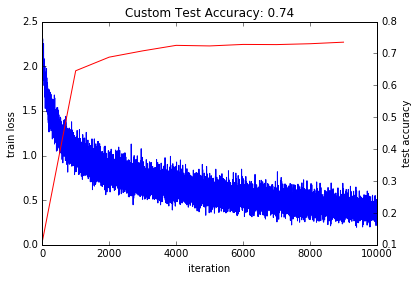

In [8]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Custom Test Accuracy: {:.2f}'.format(test_acc[-1]))